In [ ]:
!pip install --upgrade pip setuptools wheel

In [ ]:
#%% Environment Setup
%pip install torch transformers datasets opacus scikit-learn pandas requests tqdm
%pip install transformers==4.20.0  # Version with FNet support
%pip install sentencepiece
%pip install performer-pytorch opacus transformers pandas torch
%pip install pandas

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertTokenizer
from performer_pytorch import PerformerLM
from opacus import PrivacyEngine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import math
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator

In [ ]:
class Config:
    vocab_size = 30522           # Using a standard BERT tokenizer vocabulary
    hidden_size = 512            # Hidden dimension for the Performer
    bert_hidden_size = 768       # (Likely unused by your Performer model)
    num_hidden_layers = 6        # Number of Performer layers (adjust based on compute/data)
    num_attention_heads = 8      # Number of attention heads
    num_labels = 5               # 0: Stress, 1: Depression, 2: Bipolar, 3: Personality, 4: Anxiety
    max_length = 128             # Maximum sequence length
    batch_size = 32
    bert_batch_size = 16         # (Tokenizer batching parameter)
    learning_rate = 1e-4         # Standard learning rate
    num_epochs = 50
    target_epsilon = 2
    target_delta = 1e-5
    noise_multiplier = 0.00001
    max_grad_norm = 1.0
    # initializing the device to use GPU whenever available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# This is a class representing our reddit mental health dataset
class RedditMentalHealthDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Combine title and text for the model input
        combined_text = str(row['title']) + " " + str(row['text'])
        label = int(row['target'])
        encoding = self.tokenizer(
            combined_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

In [ ]:
from performer_pytorch import Performer
class PerformerForClassification(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, num_heads, num_labels, max_length, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        pe = self._build_sinusoidal_embedding(max_length, hidden_size)
        self.register_buffer("pos_emb", pe)

        dim_head = hidden_size // num_heads
        self.encoder = Performer( dim=hidden_size, depth=num_layers, heads=num_heads, dim_head=dim_head, causal=False)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def _build_sinusoidal_embedding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, input_ids, attention_mask= None):
        x = self.embedding(input_ids)                               # the token embeddings
        pe = self.pos_emb[:, : x.size(1), :]                        # perform positional embeddings
        x += pe                                                     # Add positional embeddings to the token embeddings
        if attention_mask is not None:
            x = x * attention_mask.unsqueeze(-1)
        h = self.encoder(x)                                         # passing through the encoder
        output = self.dropout(h[:, 0, :])                           # performing dropout
        return self.classifier(output)                              # getting the logits


In [ ]:
df = pd.read_csv("data_to_be_cleansed.csv")                                                                   # the reddit mental health dataset

train_df, test_df = train_test_split(df, test_size = 0.2, stratify = df['target'])                            # train-test split on our dataset
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")                                                # tokenizier for our dataset
train_dataset = RedditMentalHealthDataset(train_df, tokenizer, Config.max_length)
test_dataset = RedditMentalHealthDataset(test_df, tokenizer, Config.max_length)
train_dataloader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, drop_last= True)     # pytorch dataloader for the training dataset
test_dataloader = DataLoader(test_dataset, batch_size=Config.batch_size)                                      # pytorch dataloader for the testing dataset

In [ ]:
# Instantiate the Performer model for classification with configuration parameters
model = PerformerForClassification(
    vocab_size=Config.vocab_size,            # Size of the input vocabulary
    hidden_size=Config.hidden_size,          # Hidden dimension size of the model
    num_layers=Config.num_hidden_layers,     # Number of encoder hidden layers
    num_heads=Config.num_attention_heads,    # Number of attention heads
    num_labels=Config.num_labels,            # Number of labels our dataset
    max_length = Config.max_length,          # maximum sequenxce length
    dropout=0.1                              # dropout value
)
model.to(Config.device)                      # Putting the model on GPU

PerformerForClassification(
  (embedding): Embedding(30522, 512)
  (encoder): Performer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0-5): 6 x ModuleList(
          (0): PreLayerNorm(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (fn): SelfAttention(
              (fast_attention): FastAttention(
                (kernel_fn): ReLU()
              )
              (to_q): Linear(in_features=512, out_features=512, bias=True)
              (to_k): Linear(in_features=512, out_features=512, bias=True)
              (to_v): Linear(in_features=512, out_features=512, bias=True)
              (to_out): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (1): PreLayerNorm(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (fn): Chunk(
              (fn): FeedForward(
                (w1): Linear(in_features=5

In [ ]:
# Validate and fix model for Differential privacy
model = ModuleValidator.fix(model)
ModuleValidator.validate(model, strict=False)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.learning_rate)

# DP-compatible model, optimizer, DataLoader
privacy_engine = PrivacyEngine()
model, optimizer, train_dataloader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_dataloader,
    noise_multiplier=Config.noise_multiplier,
    max_grad_norm=Config.max_grad_norm
)

/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


In [ ]:
# Training Loop with Differential Privacy
model.train()
total_losses = []
for epoch in range(Config.num_epochs):
    loss_count = 0
    total_samples = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        # Extract inputs and labels from the batch
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        # Forward pass to get the logits
        logits = model(input_ids.to(Config.device), attention_mask.to(Config.device))
        # calculating loss using cross entropy loss
        loss = nn.CrossEntropyLoss()(logits, labels.to(Config.device))
        # Accumulate total loss scaled by batch size for averaging later
        loss_count += loss.item() * input_ids.size(0)
        total_samples += input_ids.size(0)
        # performing backpropogation
        loss.backward()
        # gradient update step
        optimizer.step()
    # Calculating epoch loss
    loss_val = loss_count / total_samples
    # Calculating total loss across all epochs
    total_losses.append(loss_val)
    print(f"Epoch {epoch+1} Loss: {loss_val:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1 Loss: 1.7326
Epoch 2 Loss: 1.8369
Epoch 3 Loss: 1.9963
Epoch 4 Loss: 1.7804
Epoch 5 Loss: 1.6978
Epoch 6 Loss: 1.6324
Epoch 7 Loss: 1.5700
Epoch 8 Loss: 1.5306


KeyboardInterrupt: 

In [ ]:
# visualising the performer loss vs the epoch during training
import matplotlib.pyplot as plt

plt.figure()
plt.plot(total_losses)
plt.title("Performer Losses")
plt.xlabel("epoch")
plt.ylabel("losses")
plt.legend()
plt.show()

In [ ]:
# testing the model performance
def evaluate(model, test_dataloader):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    total_preds = []
    total_labels = []
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for batch in test_dataloader:
          input_ids = batch["input_ids"].to(Config.device)
          attention_mask = batch["attention_mask"].to(Config.device)
          labels = batch["labels"].to(Config.device)

          logits = model(input_ids, attention_mask)
          loss = criterion(logits, labels)
          total_loss += loss.item()
          num_batches += 1
          preds = logits.argmax(dim=-1)
          total_preds.append(preds.cpu())
          total_labels.append(labels.cpu())

    total_preds = torch.cat(total_preds).numpy()
    total_labels = torch.cat(total_labels).numpy()

    avg_loss = total_loss / num_batches
    accuracy = accuracy_score(total_labels, total_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(total_labels, total_preds, average='weighted', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1

In [ ]:
#printing the evaluation metrics
avg_loss, accuracy, precision, recall, f1 = evaluate(model, test_dataloader)
print(f"Test loss:      {avg_loss:.4f}")
print(f"Test accuracy:  {accuracy:.4%}")
print(f"Test precision: {precision:.4%}")
print(f"Test recall:    {recall:.4%}")
print(f"Test F1:        {f1:.4%}")

Test loss:      3.0671
Test accuracy:  75.0839%
Test precision: 77.3396%
Test recall:    75.0839%
Test F1:        75.3921%


In [ ]:
# Drfining the model class
class TransformerForClassification(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, num_heads, num_labels, max_length, dropout = 0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        pe = self._build_sinusoidal_embedding(max_length, hidden_size)
        self.register_buffer("pos_emb", pe)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size,nhead=num_heads,dim_feedforward=4 * hidden_size,dropout=dropout,activation="gelu")
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def _build_sinusoidal_embedding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

# Forward function
    def forward(self, input_ids, attention_mask):

        x = self.embedding(input_ids)
        pe = self.pos_emb[:, : x.size(1), :]
        x += pe
        if attention_mask is not None:
            x = x * attention_mask.unsqueeze(-1)
        h = self.encoder(x)
        output = self.dropout(h[:, 0, :])
        return self.classifier(output)


In [ ]:
# Tokenising and creating the train and test dataloader
train_df, test_df = train_test_split(df, test_size = 0.2, stratify = df['target'])
transformer_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
transformer_train_dataset = RedditMentalHealthDataset(train_df, transformer_tokenizer, Config.max_length)
transformer_test_dataset = RedditMentalHealthDataset(test_df, transformer_tokenizer, Config.max_length)
transformer_train_dataloader = DataLoader(transformer_train_dataset, batch_size=Config.batch_size, shuffle=True, drop_last= True)
transformer_test_dataloader = DataLoader(transformer_test_dataset, batch_size=Config.batch_size)

In [ ]:
# Instantiate the transformer model for classification with configuration parameters
transformer_model = TransformerForClassification(
    vocab_size=Config.vocab_size,              # Size of the input vocabulary
    hidden_size=Config.hidden_size,            # Hidden dimension size of the model
    num_layers=Config.num_hidden_layers,       # Number of transformer encoder layers
    num_heads=Config.num_attention_heads,      # Number of attention heads in each layer
    num_labels=Config.num_labels,              # Number of output classes for classification
    max_length=Config.max_length,              # Maximum sequence length
    dropout=0.1                                 # Dropout rate for regularization
)

# Move the model to the specified device (CPU or GPU)
transformer_model.to(Config.device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TransformerForClassification(
  (embedding): Embedding(30522, 512)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=512, out_features=5, bias=True)
)

In [ ]:
# Validate/fix model for DP
transformer_model = ModuleValidator.fix(transformer_model)
ModuleValidator.validate(transformer_model, strict=False)

# Optimizer
transformer_optimizer = torch.optim.AdamW(transformer_model.parameters(), lr=Config.learning_rate)

# DP-compatible model, optimizer and DataLoader
privacy_engine = PrivacyEngine()
transformer_model, transformer_optimizer, transformer_train_dataloader = privacy_engine.make_private(
    module=transformer_model,
    optimizer=transformer_optimizer,
    data_loader=transformer_train_dataloader,
    noise_multiplier=Config.noise_multiplier,
    max_grad_norm=Config.max_grad_norm
)

/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


In [ ]:
# Training Loop with Differential Privacy (DP not explicitly shown here, but assumed to be integrated elsewhere)
transformer_model.train()  # Set the model to training mode
total_losses = []  # List to keep track of average loss per epoch

# Iterate over multiple epochs
for epoch in range(Config.num_epochs):
    loss_count = 0
    total_samples = 0

    # Loop through each batch in the training dataloader
    for batch in transformer_train_dataloader:
        transformer_optimizer.zero_grad()

        # Extract inputs and labels from the batch
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        # Forward pass
        logits = transformer_model(input_ids.to(Config.device), attention_mask.to(Config.device))

        # Compute cross-entropy loss between logits and true labels
        loss = nn.CrossEntropyLoss()(logits, labels.to(Config.device))

        # Accumulate total loss scaled by batch size for averaging later
        loss_count += loss.item() * input_ids.size(0)
        total_samples += input_ids.size(0)  # Update number of processed samples

        # Backward pass
        loss.backward()

        # Update model weights
        transformer_optimizer.step()

    # Calculate and store average loss for the epoch
    loss_val = loss_count / total_samples
    total_losses.append(loss_val)

    # Print epoch-wise loss
    print(f"Epoch {epoch+1} Loss: {loss_val:.4f}")

Epoch 1 Loss: 1.6531
Epoch 2 Loss: 1.6446
Epoch 3 Loss: 1.6481
Epoch 4 Loss: 1.6394
Epoch 5 Loss: 1.6336
Epoch 6 Loss: 1.6289
Epoch 7 Loss: 1.6321
Epoch 8 Loss: 1.6211
Epoch 9 Loss: 1.6279
Epoch 10 Loss: 1.6303
Epoch 11 Loss: 1.6199
Epoch 12 Loss: 1.6232
Epoch 13 Loss: 1.6245
Epoch 14 Loss: 1.6223
Epoch 15 Loss: 1.6200
Epoch 16 Loss: 1.6208
Epoch 17 Loss: 1.6195
Epoch 18 Loss: 1.6194
Epoch 19 Loss: 1.6193
Epoch 20 Loss: 1.6201
Epoch 21 Loss: 1.6171
Epoch 22 Loss: 1.6199
Epoch 23 Loss: 1.6150
Epoch 24 Loss: 1.6176
Epoch 25 Loss: 1.6155
Epoch 26 Loss: 1.6176
Epoch 27 Loss: 1.6183
Epoch 28 Loss: 1.6147
Epoch 29 Loss: 1.6156
Epoch 30 Loss: 1.6160
Epoch 31 Loss: 1.6162
Epoch 32 Loss: 1.6138
Epoch 33 Loss: 1.6185
Epoch 34 Loss: 1.6140
Epoch 35 Loss: 1.6143
Epoch 36 Loss: 1.6139
Epoch 37 Loss: 1.6139
Epoch 38 Loss: 1.6148
Epoch 39 Loss: 1.6152
Epoch 40 Loss: 1.6137
Epoch 41 Loss: 1.6145
Epoch 42 Loss: 1.6130
Epoch 43 Loss: 1.6144
Epoch 44 Loss: 1.6130
Epoch 45 Loss: 1.6141
Epoch 46 Loss: 1.61

<ipython-input-60-e4f66a88b441>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


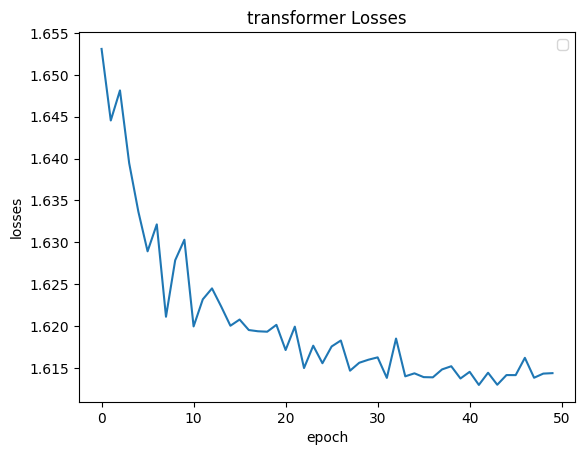

In [ ]:
import matplotlib.pyplot as plt
# Printing the loss curve of transformer
plt.figure()
plt.plot(total_losses)
plt.title("transformer Losses")
plt.xlabel("epoch")
plt.ylabel("losses")
plt.legend()
plt.show()

In [ ]:
# Printing metrics in this cell
avg_loss, accuracy, precision, recall, f1 = evaluate(transformer_model, transformer_test_dataloader)
print(f"Test loss:      {avg_loss:.4f}")
print(f"Test accuracy:  {accuracy:.4%}")
print(f"Test precision: {precision:.4%}")
print(f"Test recall:    {recall:.4%}")
print(f"Test F1:        {f1:.4%}")

Test loss:      1.6122
Test accuracy:  20.2181%
Test precision: 4.0877%
Test recall:    20.2181%
Test F1:        6.8005%
